In [423]:
import folium
from geopy.geocoders import Nominatim
import requests
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

In [422]:

df_london_tube = pd.read_excel('/Users/Chai/Desktop/Projects/Data Science/Capstone/LondonTube.xls', skiprows=3, usecols = 'A:E')

df_london_tube

,#Tube Name,Zone,PostCode,Lines,Address
0,Acton Town,3,W3 8HN,"District, Piccadilly","Acton Town Station,Station Parade,Gunnersbury ..."
1,Aldgate,1,EC3N 1AH,"Circle, Metropolitan","London Underground Ltd,Aldgate Station,9, Aldg..."
2,Aldgate East,1,E1 7PT,"District, Hammersmith","London Underground Ltd,Aldgate East Station,11..."
3,Alperton,4,HA0 4LL,Piccadilly,"London Underground Ltd,Alperton Tube,Ealing Ro..."
4,Amersham,4,HP6 5AZ,Metropolitan,"London Underground Ltd,Amersham Station,Statio..."
...,...,...,...,...,...
272,Wimbledon,3,SW19 7NL,District,"London Underground Ltd,Wimbledon Station,The B..."
273,Wimbledon Park,3,SW19 8AA,District,"London Underground Ltd,Wimbledon Park Station,..."
274,Wood Green,3,N22 6BX,Piccadilly,"High Road,London,,,N22 6BX"
275,Woodford,4,N22 5JU,Central,"Snakes Lane,Woodford Green,Essex,,N22 5JU"


In [5]:
df_london_tube['PostCodeLoc'] = df_london_tube['PostCode'].str.find(' ').fillna(0)
df_london_tube['PostCodeLoc'] = df_london_tube['PostCodeLoc'].apply(np.int64)
df_london_tube['PostCodeFirst'] = df_london_tube.apply(lambda x: x['PostCode'][:x['PostCodeLoc']], axis=1)

In [6]:
df_london_tube

,#Tube Name,Zone,PostCode,Lines,Address,PostCodeLoc,PostCodeFirst
0,Acton Town,3,W3 8HN,"District, Piccadilly","Acton Town Station,Station Parade,Gunnersbury ...",2,W3
1,Aldgate,1,EC3N 1AH,"Circle, Metropolitan","London Underground Ltd,Aldgate Station,9, Aldg...",4,EC3N
2,Aldgate East,1,E1 7PT,"District, Hammersmith","London Underground Ltd,Aldgate East Station,11...",2,E1
3,Alperton,4,HA0 4LL,Piccadilly,"London Underground Ltd,Alperton Tube,Ealing Ro...",3,HA0
4,Amersham,4,HP6 5AZ,Metropolitan,"London Underground Ltd,Amersham Station,Statio...",3,HP6
...,...,...,...,...,...,...,...
272,Wimbledon,3,SW19 7NL,District,"London Underground Ltd,Wimbledon Station,The B...",4,SW19
273,Wimbledon Park,3,SW19 8AA,District,"London Underground Ltd,Wimbledon Park Station,...",4,SW19
274,Wood Green,3,N22 6BX,Piccadilly,"High Road,London,,,N22 6BX",3,N22
275,Woodford,4,N22 5JU,Central,"Snakes Lane,Woodford Green,Essex,,N22 5JU",3,N22


In [68]:
df_london_tube[df_london_tube['Count']>1].sort_values(by=['PostCodeFirst','Count'])

,#Tube Name,Zone,PostCode,Lines,Address,PostCodeLoc,PostCodeFirst,Count
203,Shoreditch,2,E1 5EW,East London,"Brick Lane,London,,,E1 5EW",2,E1,2
221,Stepney Green,2,E1 4AQ,"District , Hammersmith","London Underground Ltd,Stepney Green Station,M...",2,E1,3
269,Whitechapel,2,E1 1BY,"District, East London, Hammersmith","London Underground Ltd,Whitechapel Railway Sta...",2,E1,4
248,Wanstead,4,E11 2NT,Central,"London Underground Ltd,Wanstead Railway Statio...",3,E11,2
149,Mudchute,2,E14 9UP,Mudchute,"East Ferry Road,London,,,E14 9UP",3,E14,2
...,...,...,...,...,...,...,...,...
155,North Ealing,3,W5 3AF,Piccadilly,"London Underground Ltd,North Ealing Station,St...",2,W5,3
171,Park Royal,3,W5 3EL,Piccadilly,"London Underground Ltd,Park Royal Station,Hang...",2,W5,4
205,South Ealing,3,W5 4QB,Piccadilly,"London Underground Ltd,South Ealing Station,So...",2,W5,5
219,Stamford Brook,2,W6 0SB,District,"London Underground Ltd,Stamford Brook Station,...",2,W6,2


In [7]:
webLink = 'https://wiki.openstreetmap.org/wiki/List_of_London_Underground_stations'
webPage = requests.get(webLink).text

soup = BeautifulSoup(webPage, 'lxml')

In [8]:
## Find class wikitable in the parsed script
london_tube_table = soup.find_all('table',{'class':'wikitable'})

## Extract relevant values within each tr/td tag, append into lists
list_tube_station = []
list_latitude = []
list_longitude = []
list_line = []

## Find all the tr tags
for table in np.arange(0,len(london_tube_table)):
    london_tube_list = london_tube_table[table].find_all('tr')
    ## Fill the lists
    for tr in range(1,len(london_tube_list[1:])+1):
        second_set = london_tube_list[tr].find_all('td')
        list_tube_station.append(second_set[0].text.strip('\n'))
        list_latitude.append(second_set[1].text.strip('\n'))
        list_longitude.append(second_set[2].text.strip('\n'))
        try:
            list_line.append(second_set[6].text.strip('\n'))
        except:
            list_line.append('DLR')

    
# ## Create a dataframe based on lists created
df_london_tube_coordinates = pd.DataFrame({'Tube Station': list_tube_station, 'Latitude': list_latitude, 'Longitude': list_longitude, 'Line': list_line})


In [9]:
df_london_tube_coordinates

,Tube Station,Latitude,Longitude,Line
0,Acton Town,51.502500,-0.278126,"District, Piccadilly"
1,Acton Central,51.50883531,-0.263033174,London Overground
2,Acton Central,51.50856013,-0.262879534,London Overground
3,Aldgate,51.51394,-0.07537,Metropolitan
4,Aldgate East,51.51514,-0.07178,"District, Hammersmith & City"
...,...,...,...,...
337,Stratford,51.540470,-0.005085,DLR
338,Tower Gateway,51.510911,-0.073466,DLR
339,Westferry,51.509576,-0.026990,DLR
340,West India Quay,51.506723,-0.019880,DLR


In [319]:
london_tube_table

<table class="wikitable" width="100%">
<caption><b>Public Domain Tube Stations List, located using a GPS</b>
</caption>
<tbody><tr>
<th>Name</th>
<th>Latitude</th>
<th>Longitude</th>
<th>Platform / Entrance</th>
<th>Collected By</th>
<th>Collected On</th>
<th>Line</th>
<th>Step free
</th></tr>
<tr>
<td>Acton Town
</td>
<td>51.502500
</td>
<td>-0.278126
</td>
<td>Platform
</td>
<td><a href="/wiki/User:Gagravarr" title="User:Gagravarr">User:Gagravarr</a>
</td>
<td>24/11/06
</td>
<td>District, Piccadilly
</td></tr>
<tr>
<td>Acton Central
</td>
<td>51.50883531
</td>
<td>-0.263033174
</td>
<td>Entrance
</td>
<td><a href="/wiki/User:Firefishy" title="User:Firefishy">User:Firefishy</a>
</td>
<td>08/05/2007
</td>
<td>London Overground
</td></tr>
<tr>
<td>Acton Central
</td>
<td>51.50856013
</td>
<td>-0.262879534
</td>
<td>Platform
</td>
<td><a href="/wiki/User:Firefishy" title="User:Firefishy">User:Firefishy</a>
</td>
<td>08/05/2007
</td>
<td>London Overground
</td></tr>
<tr>
<td>Aldgate
</td>

In [10]:
df_london_tube['#Tube Name'] = df_london_tube['#Tube Name'].str.strip()
df_london_tube['For Join1'] = df_london_tube['#Tube Name'].str.replace(' ', '')
df_london_tube['For Join1'] = df_london_tube['For Join1'].str.replace("'", "")

,#Tube Name,Zone,PostCode,Lines,Address,PostCodeLoc,PostCodeFirst,Count,For Join,For Join1
53,Colliers Wood,4,NW9 5HR,Northern,"London Underground Ltd,Collindale Station,Coll...",3,NW9,1,ColliersWood,ColliersWood
212,South Woodford,4,E18 1JJ,Central,"London Underground Ltd,South Woodford Railway ...",3,E18,0,SouthWoodford,SouthWoodford
217,St. Johns Wood,2,NW8 6DN,Jubilee,"London Underground Ltd,St. Johns Wood Station,...",3,NW8,0,St.JohnsWood,St.JohnsWood
274,Wood Green,3,N22 6BX,Piccadilly,"High Road,London,,,N22 6BX",3,N22,0,WoodGreen,WoodGreen
275,Woodford,4,N22 5JU,Central,"Snakes Lane,Woodford Green,Essex,,N22 5JU",3,N22,1,Woodford,Woodford
276,Woodside Park,4,N12 8SE,Northern,"London Underground Ltd,Woodside Park Station,S...",3,N12,0,WoodsidePark,WoodsidePark


In [11]:
df_london_tube_coordinates['For Join2'] = df_london_tube_coordinates['Tube Station'].str.replace(' ', '')
df_london_tube_coordinates['For Join2'] = df_london_tube_coordinates['For Join2'].str.replace("'", "")

In [12]:
df_london_tube_coordinates['Tube Station'] = df_london_tube_coordinates['Tube Station'].str.strip()

In [13]:
df_london_tube_full = pd.merge(df_london_tube[['#Tube Name','Zone','PostCode','Lines','PostCodeFirst','For Join1']]
                               , df_london_tube_coordinates[['Tube Station','Latitude','Longitude','For Join2']]
                               , left_on='For Join1', right_on='For Join2', how='left')

In [14]:
df_london_tube_full[pd.isnull(df_london_tube_full['Tube Station'])]

,#Tube Name,Zone,PostCode,Lines,PostCodeFirst,For Join1,Tube Station,Latitude,Longitude,For Join2
60,Dagenham Hthway,5,RM9 5AN,District,RM9,DagenhamHthway,NaN,NaN,NaN,NaN
71,Edgware Road,1,NW1 5BP,"Circle, District, Hammersmith, Bakerloo",NW1,EdgwareRoad,NaN,NaN,NaN,NaN
91,Great Portland St,1,W1N 5HE,"Circle, Hammersmith, Metropolitan",W1N,GreatPortlandSt,NaN,NaN,NaN,NaN
96,Hammersmith,2,W6 8AB,"District, Piccadilly, Metropolitan, Hammersmi...",W6,Hammersmith,NaN,NaN,NaN,NaN
100,Harrow & Weal,5,HA3 7AA,Bakerloo,HA3,Harrow&Weal,NaN,NaN,NaN,NaN
103,Heathro,6,TW6 1JJ,Picadilly,TW6,Heathro,NaN,NaN,NaN,NaN
106,High Street Ken,1,W8 5SA,"Circle, District",W8,HighStreetKen,NaN,NaN,NaN,NaN
107,Highbury & Isling,2,N5 1RA,Victoria,N5,Highbury&Isling,NaN,NaN,NaN,NaN
121,Kensington (Oly),2,W14 0NE,District,W14,Kensington(Oly),NaN,NaN,NaN,NaN
127,Kings Cross St. Pan,1,N1 9AL,"Circle, Hammersmith, Metropolitan, Northern, ...",N1,KingsCrossSt.Pan,NaN,NaN,NaN,NaN


In [15]:
df_london_tube_full = df_london_tube_full[~pd.isnull(df_london_tube_full['Tube Station'])]

In [16]:
df_london_tube_full[pd.isnull(df_london_tube_full['Tube Station'])]

,#Tube Name,Zone,PostCode,Lines,PostCodeFirst,For Join1,Tube Station,Latitude,Longitude,For Join2


In [17]:
df_london_tube_full = df_london_tube_full[['Tube Station','Zone','PostCodeFirst','PostCode','Lines','Latitude','Longitude']]

In [18]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="london_map")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of London, UK are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London, UK are 51.5073219, -0.1276474.


In [19]:
df_london_tube_full.at[df_london_tube_full['Tube Station']=='Canada Water','Latitude'] = 51.49787

In [20]:
df_london_tube_full.at[df_london_tube_full['Tube Station']=='Canada Water','Longitude'] = -0.04967

In [967]:
df_london_tube_full[df_london_tube_full['Latitude']=='(See Tube List)'].index

Int64Index([], dtype='int64')

In [21]:
df_london_tube_full.drop(df_london_tube_full[df_london_tube_full['Latitude']=='(See Tube List)'].index, inplace=True)

In [988]:
df_london_tube_full[df_london_tube_full['Tube Station']=='Bank']

,Tube Station,Zone,PostCodeFirst,PostCode,Lines,Latitude,Longitude
12,Bank,1,EC3V,EC3V 3LA,"Central, Northern, Waterloo",51.5134047,-0.08905843


In [22]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

In [23]:
# add markers to map
for lat, lng, tubestation in zip(df_london_tube_full['Latitude'], df_london_tube_full['Longitude']
                                           , df_london_tube_full['Tube Station']):
    label = '{}'.format(tubestation)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [24]:
df_london_tube_sw = df_london_tube_full[(df_london_tube_full['PostCodeFirst'].str.contains('SW'))]

In [26]:
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

In [27]:
# add markers to map
for lat, lng, tubestation in zip(df_london_tube_sw['Latitude'], df_london_tube_sw['Longitude']
                                           , df_london_tube_sw['Tube Station']):
    label = '{}'.format(tubestation)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [974]:
df_london_tube_sw

,#Tube Name,Zone,PostCode,Lines,PostCodeFirst,For Join1,Tube Station,Latitude,Longitude,For Join2
11,Balham,3,SW12 9BW,Northern,SW12,Balham,Balham,51.44344113,-0.152945844,Balham
31,Brixton,2,SW9 8HE,Victoria,SW9,Brixton,Brixton,51.46239,-0.115421,Brixton
51,Clapham Common,2,SW4 7AJ,Northern,SW4,ClaphamCommon,Clapham Common,51.46156,-0.13802,ClaphamCommon
52,Clapham North,2,SW4 7TS,Northern,SW4,ClaphamNorth,Clapham North,51.46522,-0.12950,ClaphamNorth
53,Clapham South,2,SW12 9DU,Northern,SW12,ClaphamSouth,Clapham South,51.45292257,-0.147562148,ClaphamSouth
65,Earls Court,1,SW5 9SY,"District, Picadilly",SW5,EarlsCourt,Earl's Court,51.491521,-0.193906,EarlsCourt
68,East Putney,2,SW15 2SZ,District,SW15,EastPutney,East Putney,51.459015,-0.211138,EastPutney
84,Fulham Broadway,2,SW6 1BY,District,SW6,FulhamBroadway,Fulham Broadway,51.48033,-0.19488,FulhamBroadway
86,Gloucester Road,1,SW7 4SF,"Circle, District, Piccadilly",SW7,GloucesterRoad,Gloucester Road,51.49408266,-0.17295341,GloucesterRoad
92,Green Park,1,SW1A 1BS,"Jubilee, Piccadilly, Victoria",SW1A,GreenPark,Green Park,51.50674,-0.14276,GreenPark


In [28]:
CLIENT_ID = '4ARRCW24UDLEOIFQCDPBBNU01140PWNXBWV5ZB4JGEU1225X' # your Foursquare ID
CLIENT_SECRET = 'AB2KUUDRHTLMNRAWO2IYBLE3QTXBLHXCEBJR5AB4EELILFVV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4ARRCW24UDLEOIFQCDPBBNU01140PWNXBWV5ZB4JGEU1225X
CLIENT_SECRET:AB2KUUDRHTLMNRAWO2IYBLE3QTXBLHXCEBJR5AB4EELILFVV


In [995]:
results = requests.get(url).json()

In [526]:
pd.set_option('display.max_rows', 500)

In [172]:
def get_category_type(row):
    categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [997]:
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues

69 venues were returned by Foursquare.


,name,categories,lat,lng
0,We Brought Beer,Beer Store,51.444324,-0.150656
1,M1LK,Coffee Shop,51.444450,-0.150913
2,Franco Manca,Pizza Place,51.443616,-0.149959
3,Brickwood Coffee & Bread,Coffee Shop,51.444509,-0.151127
4,Camden Coffee House,Coffee Shop,51.443271,-0.152967
5,Brother Marcus,Café,51.443668,-0.153339
6,Balham Bowls Club,Pub,51.444984,-0.152306
7,Arlo's,Steakhouse,51.444733,-0.151907
8,The Honest Italian,Pizza Place,51.442027,-0.153930
9,The Bedford,Pub,51.442756,-0.149569


In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            150)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [837]:
# Number of unique tube stations
len(london_sw_venues['Neighbourhood'].unique())

28

In [123]:
LIMIT = 150

london_sw_venues = getNearbyVenues(names=df_london_tube_sw['Tube Station'],
                                   latitudes=df_london_tube_sw['Latitude'],
                                   longitudes=df_london_tube_sw['Longitude']
                                  )

Balham
Brixton
Clapham Common
Clapham North
Clapham South
Earl's Court
East Putney
Fulham Broadway
Gloucester Road
Green Park
Hyde Park Corner
Knightsbridge
Parsons Green
Pimlico
Putney Bridge
South Kensington
South Wimbledon
Southfields
St.James's Park
Stockwell
Tooting Bec
Tooting Broadway
Vauxhall
Victoria
West Brompton
Westminster
Wimbledon
Wimbledon Park


In [56]:

# Number of unique venue categories
len(london_sw_venues['Venue Category'].unique())

226

In [32]:
def combine_category(category):
    if re.search(r'coffee|café|bakery|breakfast', str(category), re.IGNORECASE):
        return 'Café'
    elif re.search(r'supermarket|grocer', str(category), re.IGNORECASE):
        return 'Supermarket'
    elif re.search(r'restaurant|place|house|joint', str(category), re.IGNORECASE):
        return 'Restaurant'
    elif re.search(r'playground|park', str(category), re.IGNORECASE):
        return 'Playground'
    elif re.search(r'pub|bar|wine|beer', str(category), re.IGNORECASE):
        return 'Pub/Bar'
    else:
        return category
    

In [61]:
import matplotlib.pyplot as plt

In [33]:
london_sw_venues['CombinedCategory'] = london_sw_venues['Venue Category'].apply(lambda x:  combine_category(x))

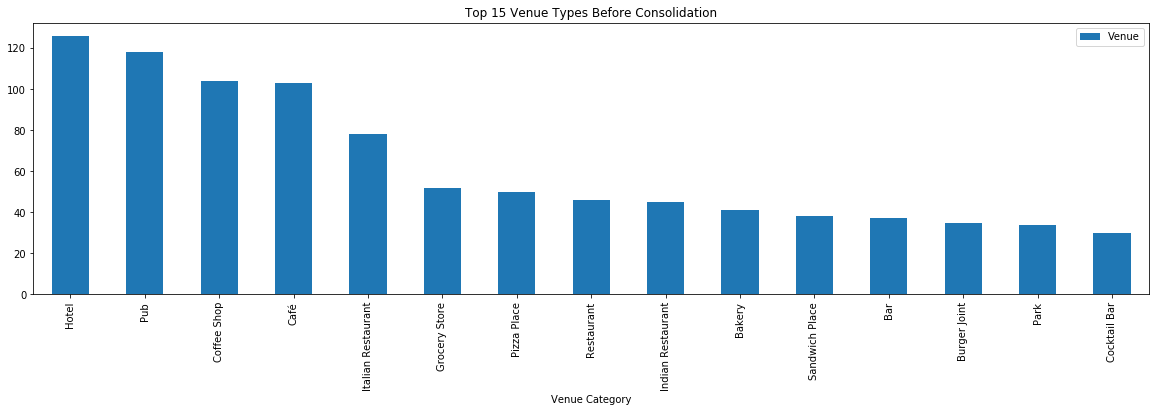

In [86]:
london_sw_venues.groupby(['Venue Category']).count().reset_index()[['Venue Category','Venue']].sort_values(by='Venue',ascending=False)[:15].plot(x='Venue Category'
                                                                                                        ,y='Venue'
                                                                                                        ,kind='bar'
                                                                                                        ,figsize=(20,5)
                                                                                                        ,title='Top 15 Venue Types Before Consolidation')

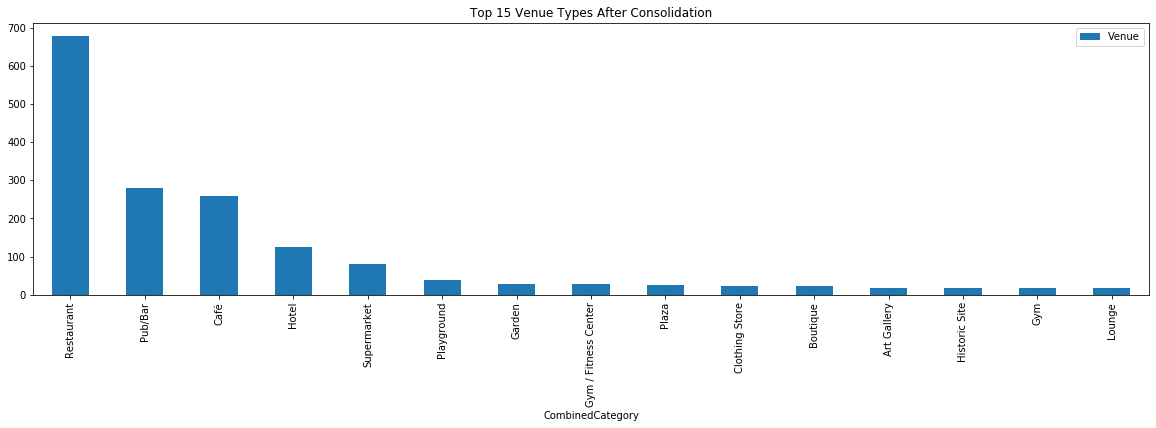

In [89]:
london_sw_venues.groupby(['CombinedCategory']).count().reset_index()[['CombinedCategory','Venue']].sort_values(by='Venue',ascending=False)[:15].plot(x='CombinedCategory'
                                                                                                        ,y='Venue'
                                                                                                        ,kind='bar'
                                                                                                        ,figsize=(20, 5)
                                                                                                        ,title='Top 15 Venue Types After Consolidation')

In [34]:
# Quick view on number of occurence in each combined categories
london_sw_venues_total_count = london_sw_venues.groupby(['CombinedCategory'], as_index=False)['Venue'].count()
london_sw_venues_total_count
# fig, ax = plt.subplots()

# london_sw_venues_total_count.plot(x='CombinedCategory', y='Venue', kind='bar', ax=ax)

,CombinedCategory,Venue
0,Antique Shop,2
1,Aquarium,1
2,Arcade,1
3,Art Gallery,18
4,Art Museum,5
...,...,...
134,Veterinarian,1
135,Video Game Store,2
136,Watch Shop,1
137,Women's Store,4


In [49]:
london_sw_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,CombinedCategory
0,Balham,51.44344113,-0.152945844,We Brought Beer,51.444324,-0.150656,Beer Store,Pub/Bar
1,Balham,51.44344113,-0.152945844,M1LK,51.444450,-0.150913,Coffee Shop,Café
2,Balham,51.44344113,-0.152945844,Franco Manca,51.443616,-0.149959,Pizza Place,Restaurant
3,Balham,51.44344113,-0.152945844,Brickwood Coffee & Bread,51.444509,-0.151127,Coffee Shop,Café
4,Balham,51.44344113,-0.152945844,Camden Coffee House,51.443271,-0.152967,Coffee Shop,Café
...,...,...,...,...,...,...,...,...
2121,Wimbledon Park,51.43391,-0.19864,Wimbledon Park London Underground Station,51.434276,-0.199265,Metro Station,Metro Station
2122,Wimbledon Park,51.43391,-0.19864,Malcom Ryan Studios,51.433135,-0.189578,Movie Theater,Movie Theater
2123,Wimbledon Park,51.43391,-0.19864,Wimbledon Park Golf Club,51.435013,-0.204357,Golf Course,Golf Course
2124,Wimbledon Park,51.43391,-0.19864,Wimbledon Park Sailing Base,51.436596,-0.205167,Sports Club,Sports Club


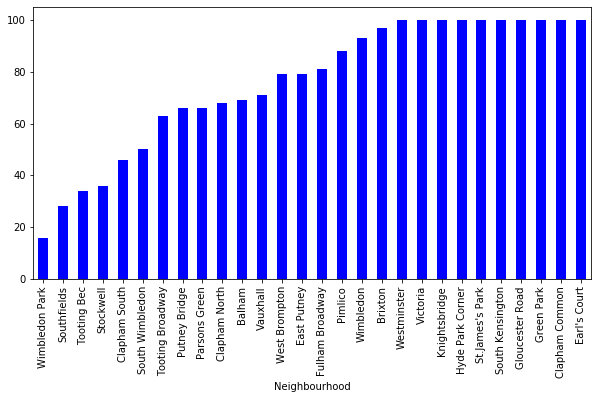

In [1047]:
# Show Number of venues by station
f = plt.figure(figsize=(10,5))
ax = f.add_subplot()
london_sw_venues_no = london_sw_venues.groupby(['Neighbourhood']).count().reset_index()
london_sw_venues_no = london_sw_venues_no.sort_values(by='Venue')
london_sw_venues_no.plot(x='Neighbourhood',y='Venue',kind='bar',color='blue',legend=None, ax=ax)

In [284]:
london_sw_venues_gr = london_sw_venues.groupby(['Neighbourhood', 'Venue Category']).count().reset_index().sort_values(by=['Neighbourhood','Venue'])

In [285]:
london_sw_venues_gr

,Neighbourhood,Venue Category,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Balham,Asian Restaurant,1,1,1,1,1
3,Balham,Beer Store,1,1,1,1,1
4,Balham,Bookstore,1,1,1,1,1
5,Balham,Breakfast Spot,1,1,1,1,1
6,Balham,Brewery,1,1,1,1,1
...,...,...,...,...,...,...,...
1177,Wimbledon Park,Sports Club,1,1,1,1,1
1178,Wimbledon Park,Tennis Court,1,1,1,1,1
1168,Wimbledon Park,Café,2,2,2,2,2
1170,Wimbledon Park,Coffee Shop,2,2,2,2,2


In [582]:
london_sw_venues_gr = london_sw_venues.groupby(['Neighbourhood', 'CombinedCategory']).count().reset_index().sort_values(by=['Neighbourhood','Venue'])

In [718]:
london_sw_venues_gr[london_sw_venues_gr['Neighbourhood']=='Balham'].sort_values(by='Venue', ascending=False)

,Neighbourhood,Venue Category,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude
12,Balham,Coffee Shop,9,9,9,9,9
32,Balham,Pub,6,6,6,6,6
29,Balham,Pizza Place,5,5,5,5,5
2,Balham,Bakery,4,4,4,4,4
38,Balham,Supermarket,3,3,3,3,3
20,Balham,Indian Restaurant,3,3,3,3,3
9,Balham,Café,3,3,3,3,3
21,Balham,Italian Restaurant,2,2,2,2,2
3,Balham,Bar,2,2,2,2,2
16,Balham,Grocery Store,2,2,2,2,2


In [124]:
london_sw_venues_onehot = pd.get_dummies(london_sw_venues[['Venue Category']], prefix='', prefix_sep='')

In [91]:
london_sw_venues_onehot = pd.get_dummies(london_sw_venues[['CombinedCategory']], prefix='', prefix_sep='')

In [125]:
london_sw_venues_onehot

,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1001]:
# london_sw_venues_onehot = pd.get_dummies(london_sw_venues[['Venue Category']], prefix='', prefix_sep='')

In [126]:
london_sw_venues_onehot['Neighbourhood'] = london_sw_venues['Neighbourhood'] 

In [41]:
london_sw_venues_onehot

,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Bike Shop,Bistro,Bookstore,...,Tour Provider,Trail,Train Station,Tram Station,Veterinarian,Video Game Store,Watch Shop,Women's Store,Yoga Studio,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Wimbledon Park
2122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Wimbledon Park
2123,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Wimbledon Park
2124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Wimbledon Park


In [47]:
london_sw_venues_onehot[london_sw_venues_onehot['Neighbourhood'] == 'Balham']

,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Bike Shop,Bistro,Bookstore,...,Tour Provider,Trail,Train Station,Tram Station,Veterinarian,Video Game Store,Watch Shop,Women's Store,Yoga Studio,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Balham


In [127]:
fixed_columns = [london_sw_venues_onehot.columns[-1]] + list(london_sw_venues_onehot.columns[:-1])

In [128]:
fixed_columns

['Neighbourhood',
 'African Restaurant',
 'American Restaurant',
 'Antique Shop',
 'Aquarium',
 'Arcade',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Australian Restaurant',
 'BBQ Joint',
 'Bakery',
 'Bar',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Store',
 'Bike Shop',
 'Bistro',
 'Bookstore',
 'Boutique',
 'Brasserie',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Burger Joint',
 'Burrito Place',
 'Bus Stop',
 'Butcher',
 'Café',
 'Camera Store',
 'Canal Lock',
 'Candy Store',
 'Cantonese Restaurant',
 'Caribbean Restaurant',
 'Caucasian Restaurant',
 'Champagne Bar',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Churrascaria',
 'Climbing Gym',
 'Clothing Store',
 'Club House',
 'Cocktail Bar',
 'Coffee Shop',
 'College Quad',
 'Concert Hall',
 'Convenience Store',
 'Cosmetics Shop',
 'Creperie',
 'Cricket Ground',
 'Cuban Restaurant',
 'Cupcake Shop',
 'Cycle Studio',
 'Dance 

In [814]:
london_sw_venues_onehot[fixed_columns]

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Balham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119,Wimbledon Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2120,Wimbledon Park,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2121,Wimbledon Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2122,Wimbledon Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
london_sw_venues_grouped = london_sw_venues_onehot.groupby('Neighbourhood').mean().reset_index()
# london_sw_venues_grouped['TotalShops'] = london_sw_venues.groupby('Neighbourhood').count().reset_index()['Venue']
london_sw_venues_grouped.shape

(28, 229)

In [820]:
london_sw_venues_grouped.drop(['TotalShops'], axis=1, inplace=True)

In [131]:
num_top_venues = 6

for hood in london_sw_venues_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = london_sw_venues_grouped[london_sw_venues_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Balham----
               venue  freq
0        Coffee Shop  0.14
1                Pub  0.09
2        Pizza Place  0.08
3             Bakery  0.06
4  Indian Restaurant  0.05
5               Café  0.05


----Brixton----
                  venue  freq
0  Caribbean Restaurant  0.05
1                   Pub  0.05
2           Coffee Shop  0.04
3           Pizza Place  0.04
4          Cocktail Bar  0.03
5  Gym / Fitness Center  0.03


----Clapham Common----
                 venue  freq
0                  Pub  0.12
1         Burger Joint  0.05
2                 Café  0.05
3           Restaurant  0.05
4          Coffee Shop  0.03
5  Japanese Restaurant  0.03


----Clapham North----
                venue  freq
0                 Pub  0.09
1                Café  0.06
2        Burger Joint  0.04
3         Coffee Shop  0.04
4                 Bar  0.04
5  Italian Restaurant  0.04


----Clapham South----
               venue  freq
0      Grocery Store  0.10
1        Pizza Place  0.08
2              

In [132]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [54]:
london_sw_venues_grouped

,Neighbourhood,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Bike Shop,Bistro,...,Thrift / Vintage Store,Tour Provider,Trail,Train Station,Tram Station,Veterinarian,Video Game Store,Watch Shop,Women's Store,Yoga Studio
0,Balham,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.015152
1,Brixton,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010417,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.010417
2,Clapham Common,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,...,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.000000,0.010000
3,Clapham North,0.000000,0.00,0.00,0.000000,0.000000,0.014925,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
4,Clapham South,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.020408
5,Earl's Court,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
6,East Putney,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,...,0.000000,0.00,0.000000,0.012987,0.000000,0.000000,0.012987,0.00,0.012987,0.012987
7,Fulham Broadway,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,Gloucester Road,0.000000,0.00,0.00,0.010000,0.010000,0.000000,0.000000,0.000000,0.010000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.010000
9,Green Park,0.000000,0.00,0.00,0.040000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.020000,0.000000


In [635]:
london_sw_venues_grouped

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Wine Shop,Winery,Women's Store,Yoga Studio,TotalShops,Total - Coffee/Cafe/Bakery,Total - Supermarket,Total - Restaurant,Total - Playground/Park,Total - Pub/Bar/Wine/Beer
0,Balham,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.014286,70,852.0,426.0,1633.0,71.0,781.0
1,Brixton,0.010101,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010101,0.000000,0.010101,99,500.0,300.0,4500.0,100.0,1500.0
2,Clapham Common,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,100,909.0,404.0,4343.0,202.0,2424.0
3,Clapham North,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.014286,...,0.000000,0.000000,0.000000,0.000000,70,639.0,142.0,1917.0,0.0,1207.0
4,Clapham South,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.043478,0.000000,0.000000,0.021739,46,47.0,282.0,705.0,47.0,423.0
5,Earl's Court,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.010000,0.000000,100,1010.0,404.0,2626.0,101.0,1515.0
6,East Putney,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.012987,0.000000,0.012987,0.012987,77,858.0,312.0,1950.0,78.0,702.0
7,Fulham Broadway,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.012821,0.000000,0.000000,0.000000,78,1027.0,316.0,1501.0,79.0,1185.0
8,Gloucester Road,0.000000,0.01,0.000000,0.00,0.00,0.010000,0.010000,0.010000,0.000000,...,0.010000,0.000000,0.000000,0.010000,100,909.0,101.0,3333.0,101.0,404.0
9,Green Park,0.000000,0.01,0.000000,0.00,0.00,0.010000,0.040000,0.010000,0.000000,...,0.010000,0.000000,0.010000,0.000000,100,101.0,101.0,3535.0,101.0,808.0


In [698]:
london_sw_venues_grouped.iloc[0, :-6]

Neighbourhood                 Balham
Antique Shop                       0
Aquarium                           0
Arcade                             0
Art Gallery                        0
Art Museum                         0
Arts & Crafts Store                0
Athletics & Sports                 0
Bed & Breakfast                    0
Bike Shop                          0
Bistro                             0
Bookstore                  0.0142857
Boutique                           0
Brasserie                          0
Breakfast Spot             0.0142857
Brewery                    0.0142857
Bus Stop                           0
Butcher                            0
Café                        0.228571
Camera Store                       0
Canal Lock                         0
Candy Store                        0
Casino                             0
Cheese Shop                        0
Chocolate Shop                     0
Churrascaria                       0
Climbing Gym                       0
C

In [133]:
import numpy as np

num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = london_sw_venues_grouped['Neighbourhood']

# return_most_common_venues(london_sw_venues_grouped.iloc[0, :], num_top_venues)

np.arange(neighbourhoods_venues_sorted.shape[0])
for ind in np.arange(london_sw_venues_grouped.shape[0]):
     neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_sw_venues_grouped.iloc[ind, :-6], num_top_venues)

neighbourhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balham,Coffee Shop,Pub,Pizza Place,Bakery,Indian Restaurant,Café,Bar,Sandwich Place,Italian Restaurant,Supermarket
1,Brixton,Caribbean Restaurant,Pub,Coffee Shop,Pizza Place,Market,Beer Bar,Gym / Fitness Center,Cocktail Bar,Tapas Restaurant,Restaurant
2,Clapham Common,Pub,Restaurant,Café,Burger Joint,Japanese Restaurant,Bar,Grocery Store,Italian Restaurant,Coffee Shop,Cocktail Bar
3,Clapham North,Pub,Café,Italian Restaurant,Coffee Shop,Cocktail Bar,Burger Joint,Bar,Bakery,Japanese Restaurant,Pizza Place
4,Clapham South,Grocery Store,Pub,Pizza Place,Indian Restaurant,Restaurant,Breakfast Spot,Bakery,Italian Restaurant,Gastropub,Supermarket
5,Earl's Court,Hotel,Pub,Italian Restaurant,Garden,Café,Pizza Place,Coffee Shop,Thai Restaurant,Supermarket,Gym / Fitness Center
6,East Putney,Coffee Shop,Bar,Clothing Store,Café,Grocery Store,Bakery,Sandwich Place,Gym / Fitness Center,Hotel,Italian Restaurant
7,Fulham Broadway,Coffee Shop,Pub,Café,Soccer Stadium,Pizza Place,Grocery Store,Restaurant,Climbing Gym,Gastropub,French Restaurant
8,Gloucester Road,Café,Hotel,Science Museum,Italian Restaurant,Bakery,Gift Shop,Burger Joint,Garden,Exhibit,Sandwich Place
9,Green Park,Boutique,Hotel,Lounge,Art Gallery,Clothing Store,Restaurant,Indian Restaurant,Seafood Restaurant,Dessert Shop,Tea Room


In [860]:
london_sw_venues_grouped['Total - Café'] = london_sw_venues_grouped['Café'] * london_sw_venues_grouped['TotalShops']

london_sw_venues_grouped['Total - Supermarket'] = london_sw_venues_grouped['Supermarket'] * london_sw_venues_grouped['TotalShops']

london_sw_venues_grouped['Total - Restaurant'] = london_sw_venues_grouped['Restaurant'] * london_sw_venues_grouped['TotalShops']

london_sw_venues_grouped['Total - Playground/Park'] = london_sw_venues_grouped['Playground'] * london_sw_venues_grouped['TotalShops']

london_sw_venues_grouped['Total - Pub/Bar'] = london_sw_venues_grouped['Pub/Bar'] * london_sw_venues_grouped['TotalShops']

In [703]:
london_sw_venues_grouped

,Neighbourhood,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Bed & Breakfast,Bike Shop,...,Video Game Store,Watch Shop,Women's Store,Yoga Studio,TotalShops,Total - Coffee/Cafe/Bakery,Total - Supermarket,Total - Restaurant,Total - Playground/Park,Total - Pub/Bar/Wine/Beer
0,Balham,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.014286,70,16.0,6.0,23.0,1.0,11.0
1,Brixton,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.010101,99,6.0,3.0,45.0,1.0,15.0
2,Clapham Common,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.010000,100,10.0,4.0,43.0,2.0,24.0
3,Clapham North,0.000000,0.00,0.00,0.000000,0.000000,0.014286,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.000000,70,12.0,2.0,27.0,0.0,17.0
4,Clapham South,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.021739,46,3.0,6.0,15.0,1.0,9.0
5,Earl's Court,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,...,0.000000,0.00,0.010000,0.000000,100,10.0,4.0,26.0,1.0,15.0
6,East Putney,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.012987,...,0.012987,0.00,0.012987,0.012987,77,14.0,4.0,25.0,1.0,9.0
7,Fulham Broadway,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.000000,78,15.0,4.0,19.0,1.0,15.0
8,Gloucester Road,0.000000,0.00,0.00,0.010000,0.010000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.00,0.000000,0.010000,100,12.0,1.0,33.0,1.0,4.0
9,Green Park,0.000000,0.00,0.00,0.040000,0.010000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.01,0.010000,0.000000,100,1.0,1.0,35.0,1.0,8.0


In [729]:
london_sw_venues_grouped.sort_values(by=['Total - Café','Total - Playground/Park']
                                     , ascending=False)

,Neighbourhood,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Bike Shop,Bistro,...,Video Game Store,Watch Shop,Women's Store,Yoga Studio,TotalShops,Total - Café,Total - Supermarket,Total - Restaurant,Total - Playground/Park,Total - Pub/Bar
12,Parsons Green,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.014706,0.000000,0.000000,...,0.000000,0.00,0.000000,0.029412,68,17.0,3.0,23.0,3.0,9.0
0,Balham,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.014286,70,17.0,6.0,23.0,1.0,11.0
23,Victoria,0.000000,0.00,0.00,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.010000,100,17.0,1.0,36.0,1.0,6.0
18,St.James's Park,0.000000,0.00,0.00,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,...,0.000000,0.00,0.000000,0.000000,100,16.0,1.0,25.0,2.0,9.0
7,Fulham Broadway,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,78,15.0,4.0,19.0,1.0,15.0
6,East Putney,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,...,0.012987,0.00,0.012987,0.012987,77,14.0,4.0,25.0,1.0,9.0
3,Clapham North,0.000000,0.00,0.00,0.000000,0.000000,0.014286,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,70,13.0,2.0,27.0,0.0,17.0
2,Clapham Common,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,...,0.000000,0.00,0.000000,0.010000,100,12.0,4.0,43.0,2.0,24.0
5,Earl's Court,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.010000,0.000000,100,12.0,4.0,26.0,1.0,15.0
8,Gloucester Road,0.000000,0.00,0.00,0.010000,0.010000,0.000000,0.000000,0.000000,0.010000,...,0.000000,0.00,0.000000,0.010000,100,12.0,1.0,33.0,1.0,4.0


In [333]:
london_sw_venues_grouped

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Veterinarian,Video Game Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Balham,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.015152
1,Brixton,0.010417,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.010417,0.000000,0.010417,0.000000,0.010417
2,Clapham Common,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.000000,0.010000
3,Clapham North,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.014925,...,0.000000,0.000000,0.000000,0.000000,0.00,0.014925,0.000000,0.000000,0.000000,0.000000
4,Clapham South,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.040816,0.000000,0.000000,0.020408
5,Earl's Court,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000
6,East Putney,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.012987,0.000000,0.012987,0.00,0.000000,0.012987,0.000000,0.012987,0.012987
7,Fulham Broadway,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.012346,0.00,0.000000,0.012346,0.000000,0.000000,0.000000
8,Gloucester Road,0.000000,0.01,0.000000,0.00,0.00,0.020000,0.010000,0.010000,0.000000,...,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,0.010000
9,Green Park,0.000000,0.01,0.000000,0.00,0.00,0.010000,0.040000,0.010000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.01,0.000000,0.010000,0.000000,0.020000,0.000000


In [825]:
london_sw_venues_grouped.columns

Index(['Neighbourhood', 'African Restaurant', 'American Restaurant',
       'Antique Shop', 'Aquarium', 'Arcade', 'Argentinian Restaurant',
       'Art Gallery', 'Art Museum', 'Arts & Crafts Store',
       ...
       'Vegetarian / Vegan Restaurant', 'Video Game Store',
       'Vietnamese Restaurant', 'Warehouse Store', 'Watch Shop', 'Wine Bar',
       'Wine Shop', 'Winery', 'Women's Store', 'Yoga Studio'],
      dtype='object', length=227)

In [437]:
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

london_sw_venues_clustering = london_sw_venues_grouped.drop(['Neighbourhood'], 1)
#                                                             ,'TotalShops','Total - Café'
#                                                             ,'Total - Playground/Park','Total - Supermarket'
#                                                             ,'Total - Restaurant', 'Total - Pub/Bar'], 1)

# kclusters = 4

# # run k-means clustering
# kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_sw_venues_clustering)

Sum_of_squared_distances = []
avg_silhouette = []
K = range(1,10)

for k in K:
    
    kclusters = k

    # # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters).fit(london_sw_venues_clustering)
    # # check cluster labels generated for each row in the dataframe
#     kmeans.labels_[0:10] 
    Sum_of_squared_distances.append(kmeans.inertia_)


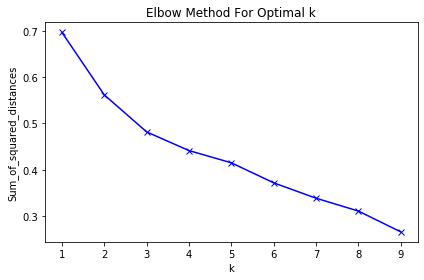

In [438]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [98]:
london_sw_venues_clustering

,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Athletics & Sports,Bike Shop,Bistro,Bookstore,...,Thrift / Vintage Store,Tour Provider,Trail,Train Station,Tram Station,Veterinarian,Video Game Store,Watch Shop,Women's Store,Yoga Studio
0,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015152,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.015152
1,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010417,...,0.010417,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.010417
2,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000,...,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.000000,0.010000
3,0.000000,0.00,0.00,0.000000,0.000000,0.014925,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
4,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.020408
5,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
6,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.012987,...,0.000000,0.00,0.000000,0.012987,0.000000,0.000000,0.012987,0.00,0.012987,0.012987
7,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
8,0.000000,0.00,0.00,0.010000,0.010000,0.000000,0.000000,0.000000,0.010000,0.010000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.010000
9,0.000000,0.00,0.00,0.040000,0.010000,0.000000,0.000000,0.000000,0.000000,0.020000,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.01,0.020000,0.000000


In [99]:
neighbourhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balham,Restaurant,Café,Pub/Bar,Supermarket,Gym / Fitness Center,Gym,Hotel,Pharmacy,Clothing Store,Shop & Service
1,Brixton,Restaurant,Pub/Bar,Café,Gym / Fitness Center,Market,Supermarket,Brewery,Food Court,Cupcake Shop,Nightclub
2,Clapham Common,Restaurant,Pub/Bar,Café,Supermarket,Playground,Gym / Fitness Center,Deli / Bodega,Creperie,Bookstore,Lounge
3,Clapham North,Restaurant,Pub/Bar,Café,Supermarket,Lounge,Clothing Store,Nightclub,Convenience Store,Bus Stop,Market
4,Clapham South,Restaurant,Pub/Bar,Supermarket,Café,Butcher,Hotel,Fish & Chips Shop,Fish Market,Gourmet Shop,Historic Site
5,Earl's Court,Hotel,Restaurant,Pub/Bar,Café,Garden,Supermarket,Gym / Fitness Center,Historic Site,Pilates Studio,Lounge
6,East Putney,Restaurant,Café,Pub/Bar,Clothing Store,Supermarket,Gym / Fitness Center,Hotel,Train Station,Bike Shop,Bookstore
7,Fulham Broadway,Restaurant,Café,Pub/Bar,Supermarket,Soccer Stadium,Climbing Gym,Gym / Fitness Center,Nightclub,Sporting Goods Shop,Ice Cream Shop
8,Gloucester Road,Restaurant,Café,Hotel,Science Museum,Pub/Bar,Exhibit,Gift Shop,Garden,Ice Cream Shop,Dessert Shop
9,Green Park,Restaurant,Pub/Bar,Boutique,Hotel,Clothing Store,Art Gallery,Lounge,Dessert Shop,Shopping Mall,Jewelry Store


In [905]:
neighbourhoods_venues_sorted.drop('Cluster Labels', axis=1, inplace=True)

In [139]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_sw_merged = df_london_tube_sw

london_sw_merged
london_sw_venues_clustering
# neighbourhoods_venues_sorted
# # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_sw_merged = pd.merge(london_sw_merged, neighbourhoods_venues_sorted, left_on='Tube Station', right_on='Neighbourhood', how='left')

# london_sw_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

london_sw_merged.head(5)

,Tube Station,Zone,PostCodeFirst,PostCode,Lines,Latitude,Longitude,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balham,3,SW12,SW12 9BW,Northern,51.44344113,-0.152945844,3,Balham,Coffee Shop,Pub,Pizza Place,Bakery,Indian Restaurant,Café,Bar,Sandwich Place,Italian Restaurant,Supermarket
1,Brixton,2,SW9,SW9 8HE,Victoria,51.46239,-0.115421,0,Brixton,Caribbean Restaurant,Pub,Coffee Shop,Pizza Place,Market,Beer Bar,Gym / Fitness Center,Cocktail Bar,Tapas Restaurant,Restaurant
2,Clapham Common,2,SW4,SW4 7AJ,Northern,51.46156,-0.13802,0,Clapham Common,Pub,Restaurant,Café,Burger Joint,Japanese Restaurant,Bar,Grocery Store,Italian Restaurant,Coffee Shop,Cocktail Bar
3,Clapham North,2,SW4,SW4 7TS,Northern,51.46522,-0.12950,0,Clapham North,Pub,Café,Italian Restaurant,Coffee Shop,Cocktail Bar,Burger Joint,Bar,Bakery,Japanese Restaurant,Pizza Place
4,Clapham South,2,SW12,SW12 9DU,Northern,51.45292257,-0.147562148,3,Clapham South,Grocery Store,Pub,Pizza Place,Indian Restaurant,Restaurant,Breakfast Spot,Bakery,Italian Restaurant,Gastropub,Supermarket


In [143]:
london_sw_merged[['Cluster Labels','Neighbourhood','1st Most Common Venue']]

,Cluster Labels,Neighbourhood,1st Most Common Venue
0,3,Balham,Coffee Shop
1,0,Brixton,Caribbean Restaurant
2,0,Clapham Common,Pub
3,0,Clapham North,Pub
4,3,Clapham South,Grocery Store
5,1,Earl's Court,Hotel
6,3,East Putney,Coffee Shop
7,3,Fulham Broadway,Coffee Shop
8,1,Gloucester Road,Café
9,1,Green Park,Boutique


In [152]:
london_sw_merged

,Tube Station,Zone,PostCodeFirst,PostCode,Lines,Latitude,Longitude,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balham,3,SW12,SW12 9BW,Northern,51.44344113,-0.152945844,3,Balham,Coffee Shop,Pub,Pizza Place,Bakery,Indian Restaurant,Café,Bar,Sandwich Place,Italian Restaurant,Supermarket
1,Brixton,2,SW9,SW9 8HE,Victoria,51.46239,-0.115421,0,Brixton,Caribbean Restaurant,Pub,Coffee Shop,Pizza Place,Market,Beer Bar,Gym / Fitness Center,Cocktail Bar,Tapas Restaurant,Restaurant
2,Clapham Common,2,SW4,SW4 7AJ,Northern,51.46156,-0.13802,0,Clapham Common,Pub,Restaurant,Café,Burger Joint,Japanese Restaurant,Bar,Grocery Store,Italian Restaurant,Coffee Shop,Cocktail Bar
3,Clapham North,2,SW4,SW4 7TS,Northern,51.46522,-0.12950,0,Clapham North,Pub,Café,Italian Restaurant,Coffee Shop,Cocktail Bar,Burger Joint,Bar,Bakery,Japanese Restaurant,Pizza Place
4,Clapham South,2,SW12,SW12 9DU,Northern,51.45292257,-0.147562148,3,Clapham South,Grocery Store,Pub,Pizza Place,Indian Restaurant,Restaurant,Breakfast Spot,Bakery,Italian Restaurant,Gastropub,Supermarket
5,Earl's Court,1,SW5,SW5 9SY,"District, Picadilly",51.491521,-0.193906,1,Earl's Court,Hotel,Pub,Italian Restaurant,Garden,Café,Pizza Place,Coffee Shop,Thai Restaurant,Supermarket,Gym / Fitness Center
6,East Putney,2,SW15,SW15 2SZ,District,51.459015,-0.211138,3,East Putney,Coffee Shop,Bar,Clothing Store,Café,Grocery Store,Bakery,Sandwich Place,Gym / Fitness Center,Hotel,Italian Restaurant
7,Fulham Broadway,2,SW6,SW6 1BY,District,51.48033,-0.19488,3,Fulham Broadway,Coffee Shop,Pub,Café,Soccer Stadium,Pizza Place,Grocery Store,Restaurant,Climbing Gym,Gastropub,French Restaurant
8,Gloucester Road,1,SW7,SW7 4SF,"Circle, District, Piccadilly",51.49408266,-0.17295341,1,Gloucester Road,Café,Hotel,Science Museum,Italian Restaurant,Bakery,Gift Shop,Burger Joint,Garden,Exhibit,Sandwich Place
9,Green Park,1,SW1A,SW1A 1BS,"Jubilee, Piccadilly, Victoria",51.50674,-0.14276,1,Green Park,Boutique,Hotel,Lounge,Art Gallery,Clothing Store,Restaurant,Indian Restaurant,Seafood Restaurant,Dessert Shop,Tea Room


<Figure size 432x288 with 0 Axes>

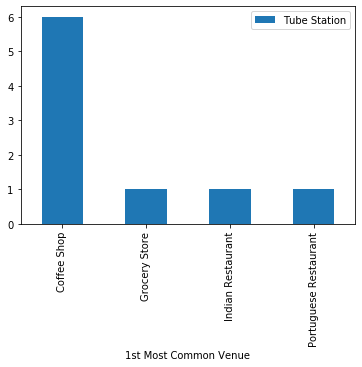

In [176]:
fig = plt.figure()
london_sw_merged[london_sw_merged['Cluster Labels']==3].groupby(['Cluster Labels'
                                                  ,'1st Most Common Venue']).count().reset_index()[['Cluster Labels'
                                                                                                    ,'1st Most Common Venue'
                                                                                                    ,'Tube Station']].plot(x='1st Most Common Venue'
                                                                                                                          ,y='Tube Station'
                                                                                                                          ,kind='bar')

In [141]:
london_sw_merged.groupby(['Cluster Labels','2nd Most Common Venue']).count().reset_index()[['Cluster Labels','2nd Most Common Venue','Tube Station']]

,Cluster Labels,2nd Most Common Venue,Tube Station
0,0,Café,2
1,0,Coffee Shop,1
2,0,Grocery Store,1
3,0,Hotel,1
4,0,Pub,2
5,0,Restaurant,1
6,1,Hotel,6
7,1,Pub,3
8,1,Restaurant,1
9,2,Café,1


In [121]:
london_sw_merged.groupby(['Cluster Labels','3rd Most Common Venue']).count().reset_index()[['Cluster Labels','3rd Most Common Venue','Tube Station']]

,Cluster Labels,3rd Most Common Venue,Tube Station
0,0,Restaurant,1
1,1,Boutique,1
2,1,Café,1
3,1,Hotel,6
4,1,Pub/Bar,4
5,2,Café,1
6,2,Pub/Bar,4
7,2,Supermarket,2
8,3,Café,7
9,3,Supermarket,1


In [186]:
london_sw_grouped = london_sw_merged.groupby(['Cluster Labels','1st Most Common Venue']).count().reset_index()[['Cluster Labels'
                                                                                            ,'1st Most Common Venue'
                                                                                            ,'Tube Station']]

In [282]:
london_sw_merged[london_sw_merged['Cluster Labels']==1]

,Tube Station,Zone,PostCodeFirst,PostCode,Lines,Latitude,Longitude,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Earl's Court,1,SW5,SW5 9SY,"District, Picadilly",51.491521,-0.193906,1,Earl's Court,Hotel,Pub,Italian Restaurant,Garden,Café,Pizza Place,Coffee Shop,Thai Restaurant,Supermarket,Gym / Fitness Center
8,Gloucester Road,1,SW7,SW7 4SF,"Circle, District, Piccadilly",51.49408266,-0.17295341,1,Gloucester Road,Café,Hotel,Science Museum,Italian Restaurant,Bakery,Gift Shop,Burger Joint,Garden,Exhibit,Sandwich Place
9,Green Park,1,SW1A,SW1A 1BS,"Jubilee, Piccadilly, Victoria",51.50674,-0.14276,1,Green Park,Boutique,Hotel,Lounge,Art Gallery,Clothing Store,Restaurant,Indian Restaurant,Seafood Restaurant,Dessert Shop,Tea Room
10,Hyde Park Corner,1,SW1X,SW1X 7LY,Piccadilly,51.50313,-0.15278,1,Hyde Park Corner,Hotel,Restaurant,Café,Lounge,Tea Room,Italian Restaurant,Cocktail Bar,Plaza,Hotel Bar,French Restaurant
11,Knightsbridge,1,SW3,SW3 1ED,Piccadilly,51.50169,-0.16030,1,Knightsbridge,Boutique,Hotel,Café,Italian Restaurant,Hotel Bar,Restaurant,Clothing Store,Jewelry Store,Coffee Shop,Tea Room
15,South Kensington,1,SW7,SW7 2NB,"Circle , District , Piccadilly",51.494066,-0.172791,1,South Kensington,Café,Hotel,Italian Restaurant,Science Museum,Burger Joint,Gift Shop,Garden,Exhibit,Bakery,Japanese Restaurant
18,St.James's Park,1,SW1H,SW1H 0QW,"Circle, District",51.49971,-0.13394,1,St.James's Park,Coffee Shop,Hotel,Sandwich Place,Monument / Landmark,Pub,Café,Plaza,Historic Site,Palace,Theater
23,Victoria,1,SW1E,SW1E 5ND,"Circle, District, Victoria",51.49662869,-0.14400853,1,Victoria,Coffee Shop,Hotel,Italian Restaurant,Bakery,Theater,Sushi Restaurant,Sandwich Place,Gym / Fitness Center,Café,Chinese Restaurant
24,West Brompton,2,SW5,SW5 9JX,District,51.48681,-0.19475,1,West Brompton,Hotel,Pub,Café,Pizza Place,Grocery Store,Italian Restaurant,Soccer Stadium,Garden,Music Venue,Gastropub
25,Westminster,1,SW1A,SW1A 2JR,"Circle, District, Jubilee",51.50121,-0.12489,1,Westminster,Hotel,Pub,Café,Plaza,Monument / Landmark,Garden,Sandwich Place,Park,Coffee Shop,Outdoor Sculpture


([<matplotlib.axis.XTick at 0x1a23212fd0>,
 <a list of 10 Text xticklabel objects>)

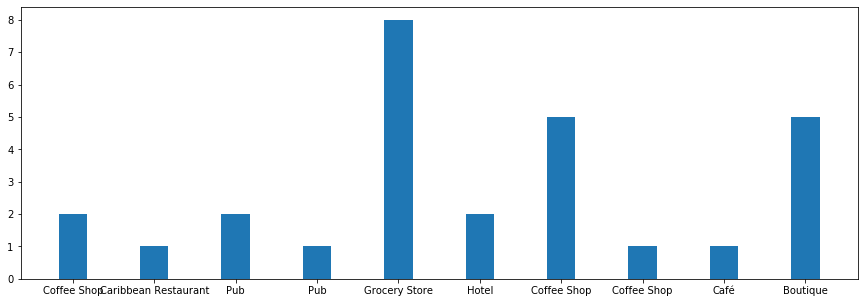

In [280]:

width = 0.35
bar_wid = 0.3

ax,fig=plt.subplots(figsize=(15,5))

N = np.arange(len(london_sw_merged['1st Most Common Venue'].unique()))

ind = [x for x, _ in enumerate(london_sw_merged['1st Most Common Venue'].unique())]

plt.bar(ind, golds, width=0.8, label='golds', color='gold', bottom=silvers+bronzes)
plt.bar(ind, silvers, width=0.8, label='silvers', color='silver', bottom=bronzes)
plt.bar(ind, bronzes, width=0.8, label='bronzes', color='#CD853F')

sub_set_df_1st = london_sw_merged[london_sw_merged['Cluster Labels']==1]
sub_set_df_2nd = london_sw_merged[london_sw_merged['Cluster Labels']==2]
sub_set_df_3rd = london_sw_merged[london_sw_merged['Cluster Labels']==3]

sub_set_df_1st = london_sw_merged.groupby(['1st Most Common Venue']).count().reset_index()[['1st Most Common Venue','Tube Station']]
N_1 = np.arange(len(sub_set_df_1st['1st Most Common Venue'].unique()))

sub_set_df_2nd = sub_set_df_2nd.groupby(['1st Most Common Venue']).count().reset_index()[['1st Most Common Venue','Tube Station']]
N_2 = np.arange(len(sub_set_df_2nd['1st Most Common Venue'].unique()))

sub_set_df_3rd = sub_set_df_3rd.groupby(['1st Most Common Venue']).count().reset_index()[['1st Most Common Venue','Tube Station']]
N_3 = np.arange(len(sub_set_df_3rd['1st Most Common Venue'].unique()))

plt.bar(N, sub_set_df_1st['Tube Station'], width)
# plt.bar(N+width, sub_set_df_1st['Tube Station'], width)
# plt.bar(N+(width*2), sub_set_df_1st['Tube Station'], width)

plt.xticks(N, london_sw_merged['1st Most Common Venue'])

In [113]:
cluster_venue_cat

,Cluster Labels,Neighbourhood
0,0,1
1,1,12
2,2,7
3,3,8


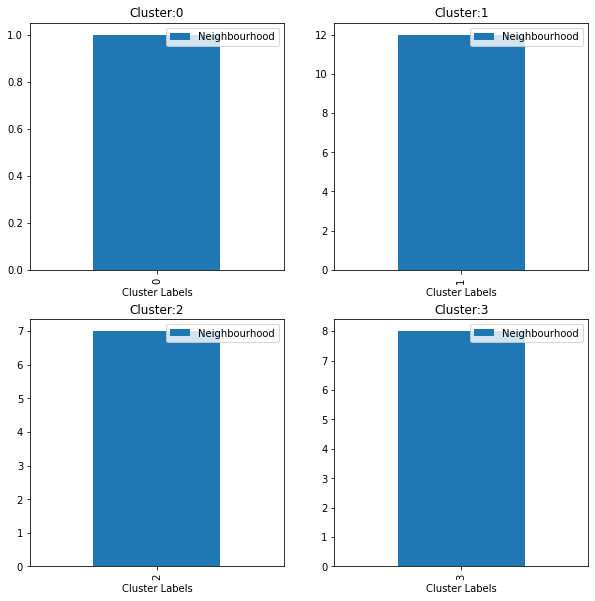

In [112]:
# cluster_venue_cat = london_sw_merged.groupby(['Cluster Labels'], as_index=False)['Neighbourhood'].count()

# cluster_venue_cat.plot(x='Cluster Labels', y='Neighbourhood', kind='bar', color='#9dd8c8')
# plt.xticks(rotation=0)
# plt.legend()

fig, axes = plt.subplots(2,2,figsize=(10,10))

for x,ax in enumerate(axes.flat):
    cluster_set = london_sw_merged[london_sw_merged['Cluster Labels']==x]
    cluster_set.plot(x='Tube Station',y='Neighbourhood', kind='bar',ax=ax)
    ax.set_title('Cluster:'+str(x))



In [927]:
cluster_venue_cat = london_sw_merged.groupby(['Cluster Labels','1st Most Common Venue','2nd Most Common Venue'
                                              ,'3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']
                                             , as_index=False)['Neighbourhood'].count()

cluster_venue_cat

# for x,ax in enumerate(axes.flat):
#     cluster_set = cluster_venue_cat[cluster_venue_cat['Cluster Labels']==x]
#     cluster_set.plot(x='Cluster Labels',y='Neighbourhood', kind='bar',ax=ax)
#     ax.set_title('Cluster:'+str(x))



,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Neighbourhood
0,0,Restaurant,Café,Pub/Bar,Hotel,Historic Site,1
1,0,Restaurant,Pub/Bar,Café,Art Gallery,Hotel,1
2,0,Restaurant,Pub/Bar,Café,Hotel,Supermarket,1
3,0,Restaurant,Pub/Bar,Hotel,Café,Plaza,1
4,1,Café,Restaurant,Pub/Bar,Supermarket,Furniture / Home Store,1
5,1,Restaurant,Café,Pub/Bar,Clothing Store,Supermarket,1
6,1,Restaurant,Café,Pub/Bar,Playground,Supermarket,1
7,1,Restaurant,Café,Pub/Bar,Supermarket,Gym / Fitness Center,1
8,1,Restaurant,Café,Pub/Bar,Supermarket,Soccer Stadium,1
9,1,Restaurant,Café,Supermarket,Pub/Bar,Bus Stop,1


In [925]:
london_sw_merged

,#Tube Name,Zone,PostCode,Lines,PostCodeFirst,For Join1,Tube Station,Latitude,Longitude,For Join2,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balham,3,SW12 9BW,Northern,SW12,Balham,Balham,51.44344113,-0.152945844,Balham,...,Restaurant,Café,Pub/Bar,Supermarket,Gym / Fitness Center,Bookstore,Pharmacy,Playground,Clothing Store,Farmers Market
1,Brixton,2,SW9 8HE,Victoria,SW9,Brixton,Brixton,51.46239,-0.115421,Brixton,...,Restaurant,Pub/Bar,Café,Gym / Fitness Center,Supermarket,Market,Food Court,Cupcake Shop,Nightclub,Brewery
2,Clapham Common,2,SW4 7AJ,Northern,SW4,ClaphamCommon,Clapham Common,51.46156,-0.13802,ClaphamCommon,...,Restaurant,Pub/Bar,Café,Supermarket,Playground,Pharmacy,Gym / Fitness Center,Massage Studio,Performing Arts Venue,Nightclub
3,Clapham North,2,SW4 7TS,Northern,SW4,ClaphamNorth,Clapham North,51.46522,-0.12950,ClaphamNorth,...,Restaurant,Pub/Bar,Café,Supermarket,Creperie,Bus Stop,Lounge,Market,Movie Theater,Pharmacy
4,Clapham South,2,SW12 9DU,Northern,SW12,ClaphamSouth,Clapham South,51.45292257,-0.147562148,ClaphamSouth,...,Restaurant,Pub/Bar,Supermarket,Café,Fish Market,Deli / Bodega,Gym / Fitness Center,Historic Site,Playground,Plaza
5,Earls Court,1,SW5 9SY,"District, Picadilly",SW5,EarlsCourt,Earl's Court,51.491521,-0.193906,EarlsCourt,...,Hotel,Restaurant,Pub/Bar,Café,Garden,Supermarket,Historic Site,Speakeasy,Farmers Market,Cupcake Shop
6,East Putney,2,SW15 2SZ,District,SW15,EastPutney,East Putney,51.459015,-0.211138,EastPutney,...,Restaurant,Café,Pub/Bar,Clothing Store,Supermarket,Hotel,Gym / Fitness Center,Train Station,Bike Shop,Bookstore
7,Fulham Broadway,2,SW6 1BY,District,SW6,FulhamBroadway,Fulham Broadway,51.48033,-0.19488,FulhamBroadway,...,Restaurant,Café,Pub/Bar,Supermarket,Soccer Stadium,Gym / Fitness Center,Sporting Goods Shop,Climbing Gym,Farmers Market,Fish & Chips Shop
8,Gloucester Road,1,SW7 4SF,"Circle, District, Piccadilly",SW7,GloucesterRoad,Gloucester Road,51.49408266,-0.17295341,GloucesterRoad,...,Restaurant,Café,Hotel,Pub/Bar,Science Museum,Gift Shop,Garden,Exhibit,Gym / Fitness Center,Dessert Shop
9,Green Park,1,SW1A 1BS,"Jubilee, Piccadilly, Victoria",SW1A,GreenPark,Green Park,51.50674,-0.14276,GreenPark,...,Restaurant,Pub/Bar,Hotel,Boutique,Clothing Store,Art Gallery,Lounge,Dessert Shop,Social Club,Shopping Mall


In [346]:
cluster_venue_cat_1
cluster_venue_cat_2 

,Cluster Labels,2nd Most Common Venue,Neighbourhood
0,0,Café,2
1,0,Coffee Shop,1
2,0,Grocery Store,1
3,0,Hotel,1
4,0,Pub,2
5,0,Restaurant,1
6,1,Hotel,6
7,1,Pub,3
8,1,Restaurant,1
9,2,Café,1


In [358]:
cluster_venue_cat = london_sw_merged.groupby(['Cluster Labels','1st Most Common Venue'])['Neighbourhood'].count().reset_index().sort_values(by=['Cluster Labels','Neighbourhood'],ascending=False)

cluster_venue_cat

,Cluster Labels,1st Most Common Venue,Neighbourhood
9,3,Coffee Shop,6
10,3,Grocery Store,1
11,3,Indian Restaurant,1
12,3,Portuguese Restaurant,1
8,2,Grocery Store,1
7,1,Hotel,4
4,1,Boutique,2
5,1,Café,2
6,1,Coffee Shop,2
3,0,Pub,5


In [372]:
london_sw_merged

,Tube Station,Zone,PostCodeFirst,PostCode,Lines,Latitude,Longitude,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Pimlico,1,SW1V,SW1V 2PU,Victoria,51.489081,-0.133037,0,Pimlico,Hotel,Pub,Park,Sandwich Place,Pizza Place,Restaurant,Indian Restaurant,Turkish Restaurant,Deli / Bodega,Art Gallery
1,Brixton,2,SW9,SW9 8HE,Victoria,51.46239,-0.115421,0,Brixton,Caribbean Restaurant,Pub,Coffee Shop,Pizza Place,Market,Beer Bar,Gym / Fitness Center,Cocktail Bar,Tapas Restaurant,Restaurant
2,Clapham Common,2,SW4,SW4 7AJ,Northern,51.46156,-0.13802,0,Clapham Common,Pub,Restaurant,Café,Burger Joint,Japanese Restaurant,Bar,Grocery Store,Italian Restaurant,Coffee Shop,Cocktail Bar
3,Clapham North,2,SW4,SW4 7TS,Northern,51.46522,-0.12950,0,Clapham North,Pub,Café,Italian Restaurant,Coffee Shop,Cocktail Bar,Burger Joint,Bar,Bakery,Japanese Restaurant,Pizza Place
14,Putney Bridge,2,SW6,SW6 3UH,District,51.46868,-0.2088141,0,Putney Bridge,Pub,Café,Italian Restaurant,Park,Mediterranean Restaurant,Thai Restaurant,Farmers Market,Fast Food Restaurant,Coffee Shop,Cocktail Bar
26,Wimbledon,3,SW19,SW19 7NL,District,51.42200,-0.20544,0,Wimbledon,Pub,Coffee Shop,Bar,Clothing Store,Sushi Restaurant,Italian Restaurant,Burger Joint,Supermarket,Grocery Store,Sandwich Place
22,Vauxhall,1,SW8,SW8 2LG,Victoria,51.48603,-0.12369,0,Vauxhall,Pub,Hotel,Art Gallery,Café,Restaurant,Cricket Ground,Park,Gay Bar,Portuguese Restaurant,Italian Restaurant
16,South Wimbledon,3,SW19,SW19 1DE,Northern,51.41543048,-0.192262754,0,South Wimbledon,Bus Stop,Grocery Store,Thai Restaurant,Pub,Café,Bar,Sushi Restaurant,Coffee Shop,Chinese Restaurant,Lebanese Restaurant
24,West Brompton,2,SW5,SW5 9JX,District,51.48681,-0.19475,1,West Brompton,Hotel,Pub,Café,Pizza Place,Grocery Store,Italian Restaurant,Soccer Stadium,Garden,Music Venue,Gastropub
18,St.James's Park,1,SW1H,SW1H 0QW,"Circle, District",51.49971,-0.13394,1,St.James's Park,Coffee Shop,Hotel,Sandwich Place,Monument / Landmark,Pub,Café,Plaza,Historic Site,Palace,Theater


In [400]:
%matplotlib inline

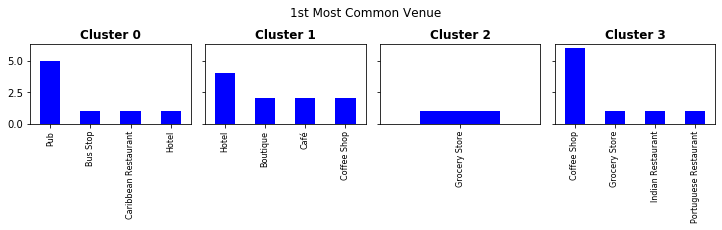

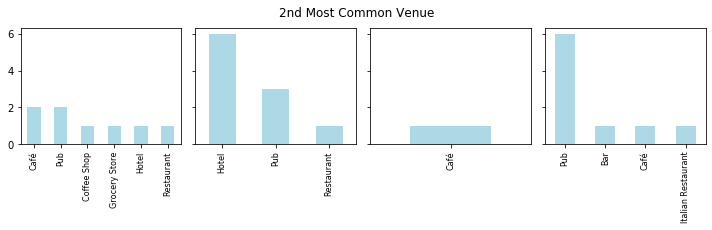

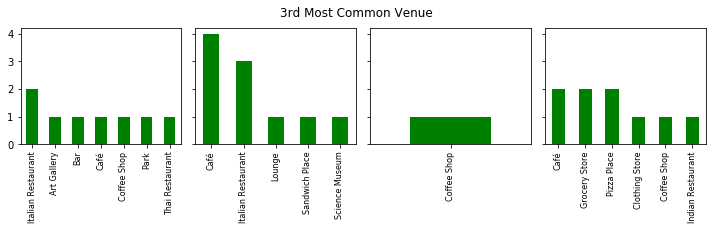

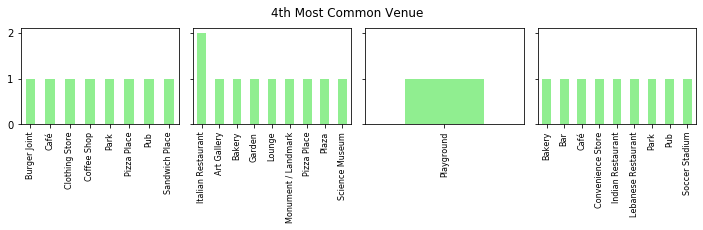

In [407]:
# cluster_venue_cat = london_sw_merged.groupby(['Cluster Labels','1st Most Common Venue','2nd Most Common Venue'], as_index=False)['Neighbourhood'].count()
london_sw_merged.sort_values(by='Cluster Labels', inplace=True)

fig, axes = plt.subplots(1,4,figsize=(10,3), sharey=True)

# fig.tight_layout()

plt.rcParams.update({'figure.autolayout': True})

for ax,x in zip(axes.flat, london_sw_merged['Cluster Labels'].unique()):
    cluster_venue_cat = london_sw_merged[london_sw_merged['Cluster Labels']==x]
    cluster_venue_grouped = cluster_venue_cat.groupby(['Cluster Labels','1st Most Common Venue'])['Neighbourhood'].count().reset_index() \
                                                .sort_values(by=['Cluster Labels','Neighbourhood'],ascending=False)
    cluster_venue_grouped.plot(x='1st Most Common Venue',y='Neighbourhood', kind='bar',ax=ax, color='blue')
    ax.set_title('Cluster '+str(x), fontweight='bold')
    ax.set_xticklabels(cluster_venue_grouped['1st Most Common Venue'],rotation=90,fontsize=8)
    ax.xaxis.set_label_text('')
    ax.get_legend().remove()

fig.suptitle('1st Most Common Venue', fontsize=12, y=1.05)

fig, axes = plt.subplots(1,4,figsize=(10,3), sharey=True)

for ax,x in zip(axes.flat, london_sw_merged['Cluster Labels'].unique()):
    cluster_venue_cat = london_sw_merged[london_sw_merged['Cluster Labels']==x]
    cluster_venue_grouped = cluster_venue_cat.groupby(['Cluster Labels','2nd Most Common Venue'])['Neighbourhood'].count().reset_index() \
                                        .sort_values(by=['Cluster Labels','Neighbourhood'],ascending=False)
    cluster_venue_grouped.plot(x='2nd Most Common Venue',y='Neighbourhood', kind='bar',ax=ax, color='lightblue')
    ax.set_title('Cluster '+str(x))
    ax.set_xticklabels(cluster_venue_grouped['2nd Most Common Venue'],rotation=90,fontsize=8)
    ax.xaxis.set_label_text('')
    ax.get_legend().remove()
    ax.set_title('')

fig.suptitle('2nd Most Common Venue', fontsize=12, y=1.05)
    
fig, axes = plt.subplots(1,4,figsize=(10,3), sharey=True)

for ax,x in zip(axes.flat, london_sw_merged['Cluster Labels'].unique()):
    cluster_venue_cat = london_sw_merged[london_sw_merged['Cluster Labels']==x]
    cluster_venue_grouped = cluster_venue_cat.groupby(['Cluster Labels','3rd Most Common Venue'])['Neighbourhood'].count().reset_index() \
                                        .sort_values(by=['Cluster Labels','Neighbourhood'],ascending=False)
    cluster_venue_grouped.plot(x='3rd Most Common Venue',y='Neighbourhood', kind='bar',ax=ax, color='green')
    ax.set_title('Cluster '+str(x))
    ax.set_xticklabels(cluster_venue_grouped['3rd Most Common Venue'],rotation=90,fontsize=8)
    ax.xaxis.set_label_text('')
    ax.get_legend().remove()
    ax.set_title('')

fig.suptitle('3rd Most Common Venue', fontsize=12, y=1.05)
    
fig, axes = plt.subplots(1,4,figsize=(10,3), sharey=True)

for ax,x in zip(axes.flat, london_sw_merged['Cluster Labels'].unique()):
    cluster_venue_cat = london_sw_merged[london_sw_merged['Cluster Labels']==x]
    cluster_venue_grouped = cluster_venue_cat.groupby(['Cluster Labels','4th Most Common Venue'])['Neighbourhood'].count().reset_index() \
                                        .sort_values(by=['Cluster Labels','Neighbourhood'],ascending=False)
    cluster_venue_grouped.plot(x='4th Most Common Venue',y='Neighbourhood', kind='bar',ax=ax, color='lightgreen')
    ax.set_title('Cluster '+str(x))
    ax.set_xticklabels(cluster_venue_grouped['4th Most Common Venue'],rotation=90,fontsize=8)
    ax.xaxis.set_label_text('')
    ax.get_legend().remove()
    ax.set_title('')
  
fig.suptitle('4th Most Common Venue', fontsize=12, y=1.05)

plt.show()


In [418]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(london_sw_merged['Latitude'], london_sw_merged['Longitude'], london_sw_merged['Neighbourhood'], london_sw_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [434]:

london_sw_clusters = london_sw_merged.loc[london_sw_merged['Cluster Labels'].isin([2,3])]

In [436]:
london_sw_clusters.to_csv('/Users/Chai/Desktop/Projects/Data Science/Capstone/london_sw_clusters.csv')

In [433]:
london_sw_merged

,Tube Station,Zone,PostCodeFirst,PostCode,Lines,Latitude,Longitude,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Pimlico,1,SW1V,SW1V 2PU,Victoria,51.489081,-0.133037,0,Pimlico,Hotel,Pub,Park,Sandwich Place,Pizza Place,Restaurant,Indian Restaurant,Turkish Restaurant,Deli / Bodega,Art Gallery
1,Brixton,2,SW9,SW9 8HE,Victoria,51.46239,-0.115421,0,Brixton,Caribbean Restaurant,Pub,Coffee Shop,Pizza Place,Market,Beer Bar,Gym / Fitness Center,Cocktail Bar,Tapas Restaurant,Restaurant
2,Clapham Common,2,SW4,SW4 7AJ,Northern,51.46156,-0.13802,0,Clapham Common,Pub,Restaurant,Café,Burger Joint,Japanese Restaurant,Bar,Grocery Store,Italian Restaurant,Coffee Shop,Cocktail Bar
3,Clapham North,2,SW4,SW4 7TS,Northern,51.46522,-0.12950,0,Clapham North,Pub,Café,Italian Restaurant,Coffee Shop,Cocktail Bar,Burger Joint,Bar,Bakery,Japanese Restaurant,Pizza Place
14,Putney Bridge,2,SW6,SW6 3UH,District,51.46868,-0.2088141,0,Putney Bridge,Pub,Café,Italian Restaurant,Park,Mediterranean Restaurant,Thai Restaurant,Farmers Market,Fast Food Restaurant,Coffee Shop,Cocktail Bar
26,Wimbledon,3,SW19,SW19 7NL,District,51.42200,-0.20544,0,Wimbledon,Pub,Coffee Shop,Bar,Clothing Store,Sushi Restaurant,Italian Restaurant,Burger Joint,Supermarket,Grocery Store,Sandwich Place
22,Vauxhall,1,SW8,SW8 2LG,Victoria,51.48603,-0.12369,0,Vauxhall,Pub,Hotel,Art Gallery,Café,Restaurant,Cricket Ground,Park,Gay Bar,Portuguese Restaurant,Italian Restaurant
16,South Wimbledon,3,SW19,SW19 1DE,Northern,51.41543048,-0.192262754,0,South Wimbledon,Bus Stop,Grocery Store,Thai Restaurant,Pub,Café,Bar,Sushi Restaurant,Coffee Shop,Chinese Restaurant,Lebanese Restaurant
8,Gloucester Road,1,SW7,SW7 4SF,"Circle, District, Piccadilly",51.49408266,-0.17295341,1,Gloucester Road,Café,Hotel,Science Museum,Italian Restaurant,Bakery,Gift Shop,Burger Joint,Garden,Exhibit,Sandwich Place
9,Green Park,1,SW1A,SW1A 1BS,"Jubilee, Piccadilly, Victoria",51.50674,-0.14276,1,Green Park,Boutique,Hotel,Lounge,Art Gallery,Clothing Store,Restaurant,Indian Restaurant,Seafood Restaurant,Dessert Shop,Tea Room
